In [34]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision
import numpy as np
import wandb
from datetime import date
import pandas as pd
import os

from conv_net import *
from conv_traintest import *
from utils import *
from FTTP import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seed
torch.manual_seed(999)

cuda


In [35]:
###############################################################
# IMPORT DATASET
###############################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 200

testdata = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

# data loading
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# check data loading correctness
for batch_idx, (data, target) in enumerate(test_loader):
    sample_data = data
    print(data.shape)
    _, c, h, w = data.shape
    break

torch.Size([200, 1, 28, 28])


In [36]:
# training parameters
T = 20
n_classes = 10

###############################################################
# DEFINE NETWORK
###############################################################

# set input and t param

IN_dim = [c, h, w]
hidden_channels = [8, 8, 8]
kernel_size = [3, 3, 3]
stride = [1, 1, 1]
paddings = [0, 0, 0]
pooling = None
num_readout = 10
conv_adp = True
syn_curr_conv = False
is_rec = [False, False, False]
dp=0.2


# define network
model = SnnConvNet(IN_dim, hidden_channels, kernel_size, stride,
                   paddings, n_classes, is_adapt_conv=conv_adp,
                   syn_curr_conv=syn_curr_conv, dp_rate=dp, p_size=num_readout, 
                   pooling=pooling, is_rec=is_rec)
model.to(device)
print(model)

SNN-conv + None
output size 5408
SNN-conv + None
output size 4608
SnnConvNet(
  (dp): Dropout2d(p=0.2, inplace=False)
  (h_layer): SnnLayer(
    (fc_weights): Linear(in_features=784, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (conv1): SNNConvCell(
    (conv_in): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): SNNConvCell(
    (conv_in): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_to_pop): Linear(in_features=4608, out_features=100, bias=True)
  (pop_enc): SnnLayer(
    (rec_w): Linear(in_features=100, out_features=100, bias=True)
    (sigmoid): Sigmoid()
  )
  (pop_to_conv): Linear(in_features=100, out_features=4608, bias=True)
  (deconv2): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (deconv1): ConvTr

In [37]:
def model_result_dict_load(fn):
    """load tar file with saved model

    Args:
        fn (str): tar file name

    Returns:
        dict: dictornary containing saved results
    """
    with open(fn, 'rb') as f:
        dict = torch.load(f, map_location='cpu')
    return dict

exp_dir = '/home/lucy/spikingPC/results/Mar-06-2023/conv_fptt_ener1_rec_conv_2l_poisson2/'
saved_dict = model_result_dict_load(exp_dir + 'onelayer_rec_best.pth.tar')

model.load_state_dict(saved_dict['state_dict'])
model.eval()

SnnConvNet(
  (dp): Dropout2d(p=0.2, inplace=False)
  (h_layer): SnnLayer(
    (fc_weights): Linear(in_features=784, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (conv1): SNNConvCell(
    (conv_in): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): SNNConvCell(
    (conv_in): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (sigmoid): Sigmoid()
    (BN): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_to_pop): Linear(in_features=4608, out_features=100, bias=True)
  (pop_enc): SnnLayer(
    (rec_w): Linear(in_features=100, out_features=100, bias=True)
    (sigmoid): Sigmoid()
  )
  (pop_to_conv): Linear(in_features=100, out_features=4608, bias=True)
  (deconv2): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (deconv1): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
  (output_layer

In [38]:
param_names = []
param_dict = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        param_names.append(name)
        param_dict[name] = param.detach().cpu().numpy()

print(param_names)

['h_layer.tau_adp', 'h_layer.tau_m', 'h_layer.tau_i', 'h_layer.fc_weights.weight', 'h_layer.fc_weights.bias', 'conv1.tau_m', 'conv1.tau_adp', 'conv1.tau_i', 'conv1.conv_in.weight', 'conv1.conv_in.bias', 'conv1.BN.weight', 'conv1.BN.bias', 'conv2.tau_m', 'conv2.tau_adp', 'conv2.tau_i', 'conv2.conv_in.weight', 'conv2.conv_in.bias', 'conv2.BN.weight', 'conv2.BN.bias', 'conv_to_pop.weight', 'conv_to_pop.bias', 'pop_enc.tau_adp', 'pop_enc.tau_m', 'pop_enc.tau_i', 'pop_enc.rec_w.weight', 'pop_enc.rec_w.bias', 'pop_to_conv.weight', 'pop_to_conv.bias', 'deconv2.weight', 'deconv2.bias', 'deconv1.weight', 'deconv1.bias']


In [39]:
weights = [x for x in param_names if ('weight' in x) and ('BN' not in x)][2:] # exclude h layer weights
weights

['conv1.conv_in.weight',
 'conv2.conv_in.weight',
 'conv_to_pop.weight',
 'pop_enc.rec_w.weight',
 'pop_to_conv.weight',
 'deconv2.weight',
 'deconv1.weight']

In [40]:
connection_type = ['ff', 'ff', 'ff', 'rec', 'fb', 'fb', 'fb']
# connection_type = ['ff', 'ff', 'ff', 'rec', 'fb', 'fb', 'fb', 'ff', 'fb']

# connection_type = ['ff', 'ff', 'rec', 'fb', 'fb']

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'conv1.conv_in.weight'),
  Text(1, 0, 'conv2.conv_in.weight'),
  Text(2, 0, 'conv_to_pop.weight'),
  Text(3, 0, 'pop_enc.rec_w.weight'),
  Text(4, 0, 'pop_to_conv.weight'),
  Text(5, 0, 'deconv2.weight'),
  Text(6, 0, 'deconv1.weight')])

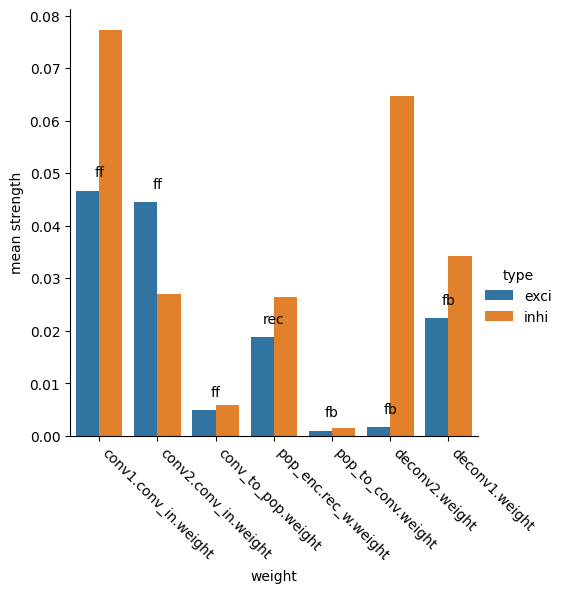

In [41]:
exci = []
inhi = []

for name in weights:
    w = param_dict[name]
    exci.append(((w>0)*w).mean())
    inhi.append(-((w<0)*w).mean())

df = pd.DataFrame({
    'weight': weights * 2,
    'connection type': connection_type * 2,
    'mean strength': exci + inhi,
    'type': ['exci'] * len(exci) + ['inhi'] * len(inhi)
})

sns.catplot(
    data=df, x="weight", y="mean strength", hue='type',
    kind="bar"
)

for i, label in enumerate(weights):
    plt.annotate(connection_type[i], (i, df['mean strength'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xticks(rotation=-45, ha='left')


<AxesSubplot: >

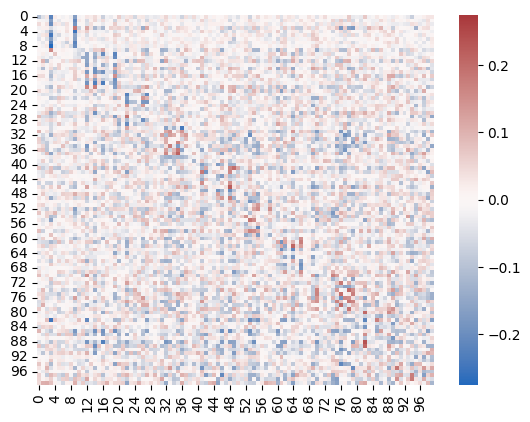

In [42]:
max = np.max(np.abs(param_dict['pop_enc.rec_w.weight']))
sns.heatmap(param_dict['pop_enc.rec_w.weight'], cmap='vlag', vmax=max, vmin=-max)

In [43]:
model.output_layer.tau_m

Parameter containing:
tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000], device='cuda:0')

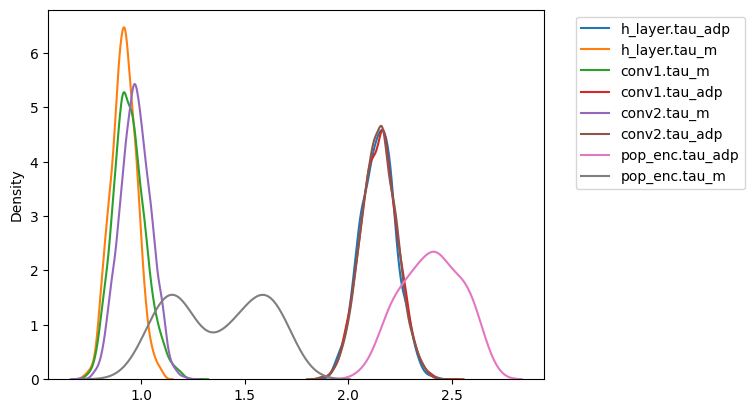

In [83]:
fig, ax = plt.subplots()

# plot your data
for name, param in param_dict.items():
    if 'tau_m' in name or 'tau_adp' in name:
        sns.kdeplot(param.flatten(), label=name, ax=ax)

# create legend outside plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

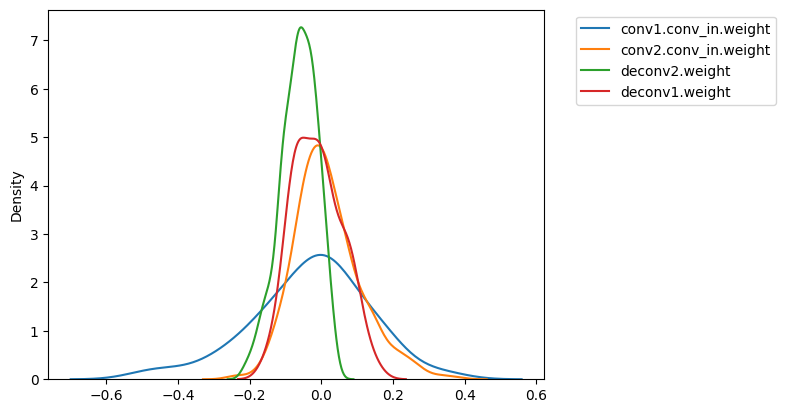

In [82]:
fig, ax = plt.subplots()

# plot your data
for name, param in param_dict.items():
    if ('conv_in' in name or 'deconv' in name) and 'weight' in name:
        sns.kdeplot(param.flatten(), label=name, ax=ax)

# create legend outside plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

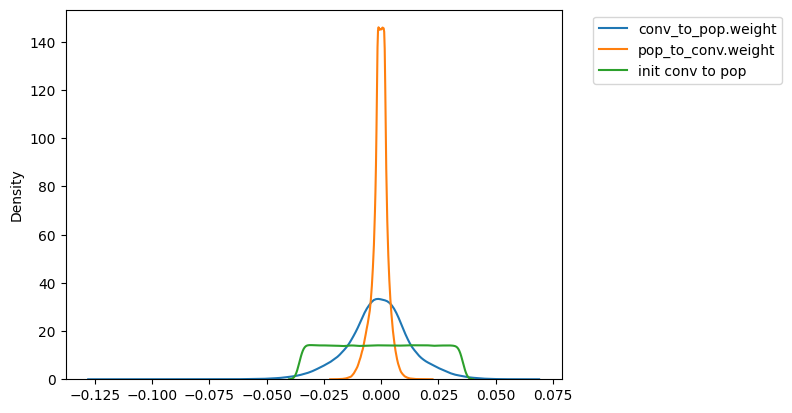

In [80]:
fig, ax = plt.subplots()

# plot your data
for name, param in param_dict.items():
    if ('pop' in name and 'conv' in name) and 'weight' in name:
        sns.kdeplot(param.flatten(), label=name, ax=ax)

# plot init dist
sns.kdeplot(nn.init.xavier_uniform_(torch.Tensor(model.conv_to_pop.weight.shape)).flatten(), label='init conv to pop')

# create legend outside plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

<AxesSubplot: ylabel='Density'>

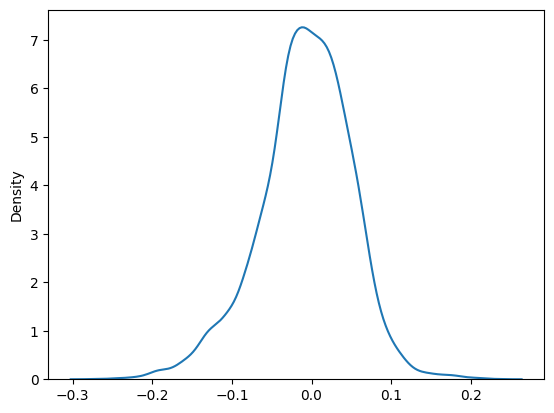

In [84]:
sns.kdeplot(param_dict['pop_enc.rec_w.weight'].flatten())

<AxesSubplot: >

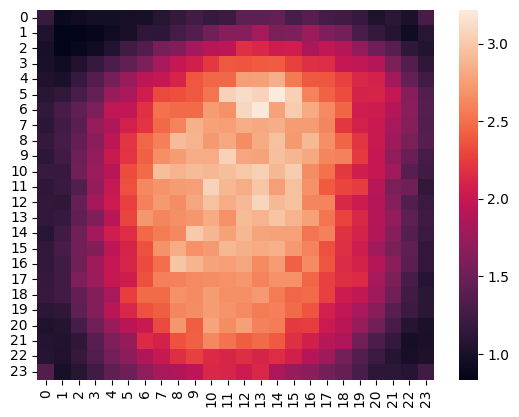

In [70]:
# concentration of weights on 2d plane 
sns.heatmap((torch.abs(model.pop_to_conv.weight.detach().cpu())).sum(dim=1).reshape(model.conv2.output_shape).sum(dim=0))

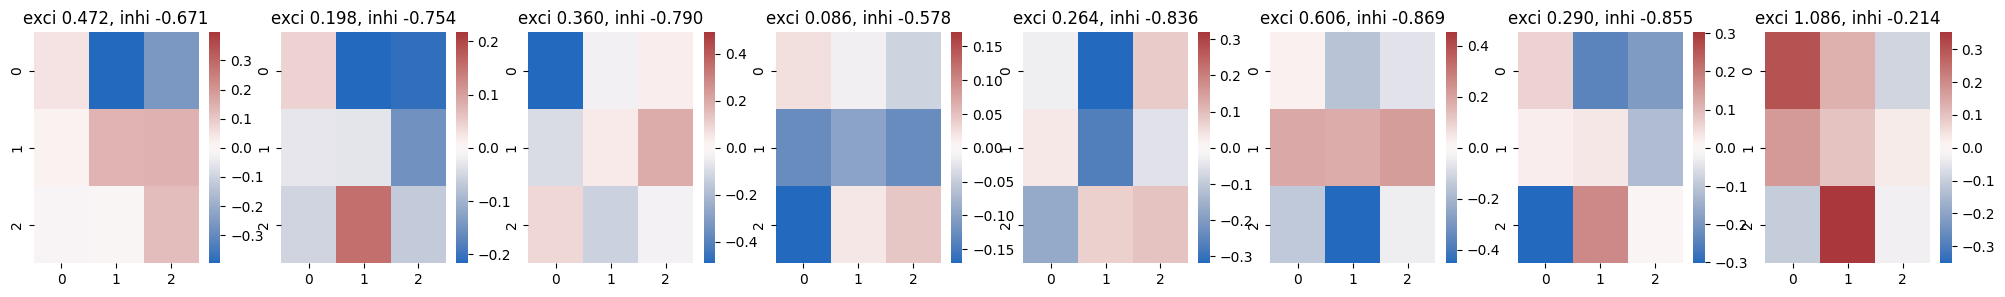

In [48]:
k = model.conv1.conv_in.weight.detach().cpu().numpy()

fig, axs = plt.subplots(1, len(k), figsize=(25, 3))
plt.title('conv 1 kernels')
for i in range(len(k)):
    abs_max = np.max(np.abs(k[i]))
    sns.heatmap(k[i].squeeze(), ax=axs[i], vmax=abs_max, vmin=-abs_max, cmap='vlag')
    axs[i].set_title('exci %.3f, inhi %.3f' % (((k[i]>0)*k[i]).sum(), ((k[i]<0)*k[i]).sum()))
plt.show()

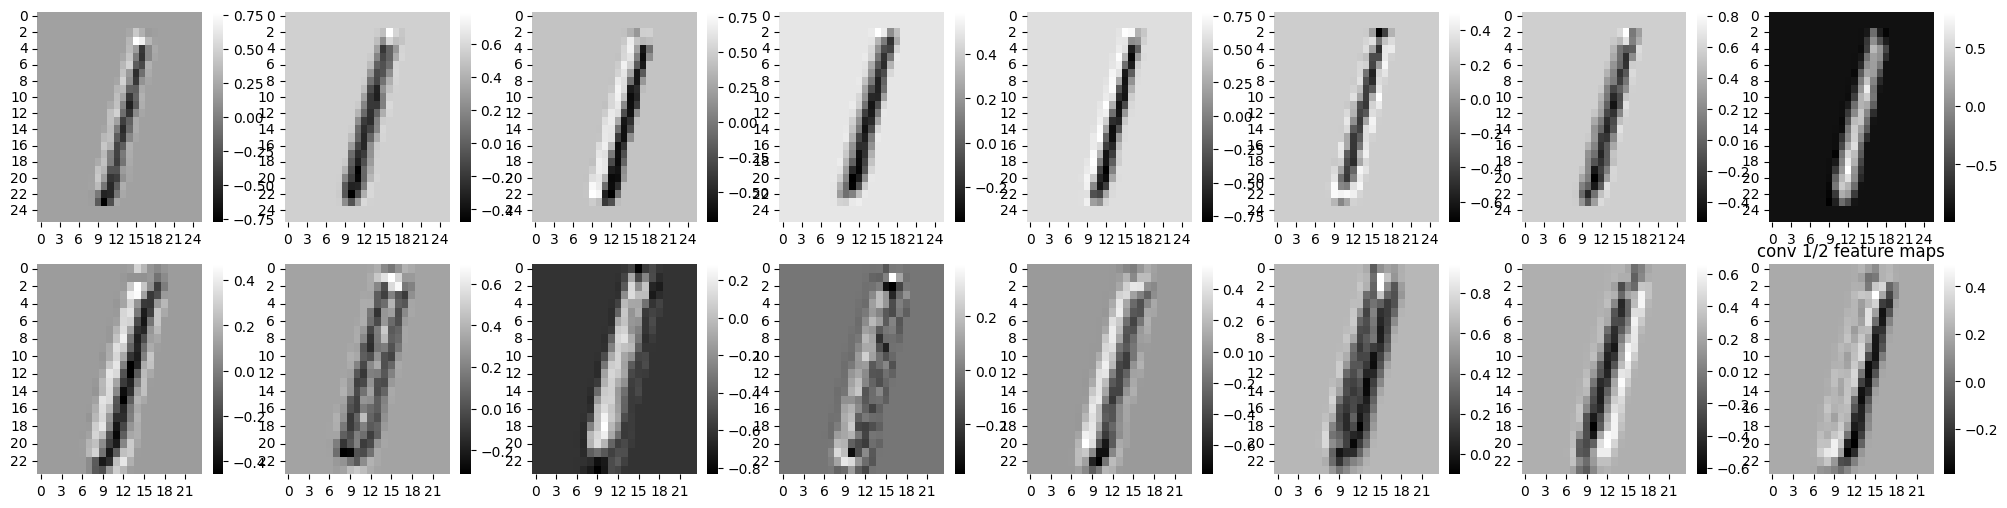

In [49]:
img = sample_data[2]
conv1 = model.conv1.conv_in.weight.detach().cpu()
conv1_bias = model.conv1.conv_in.bias.detach().cpu()

conv2 = model.conv2.conv_in.weight.detach().cpu()
conv2_bias = model.conv2.conv_in.bias.detach().cpu()

feature1 = F.conv2d(img, conv1, bias=conv1_bias, stride=1, padding=0)
feature2 = F.conv2d(feature1, conv2, bias=conv2_bias, stride=1, padding=0)


fig, axs = plt.subplots(2, len(conv1), figsize=(25, 6))
plt.title('conv 1/2 feature maps')
for i in range(len(conv1)):
    sns.heatmap(feature1[i].squeeze(), ax=axs[0][i], cmap='gray')
    sns.heatmap(feature2[i].squeeze(), ax=axs[1][i], cmap='gray')
plt.show()

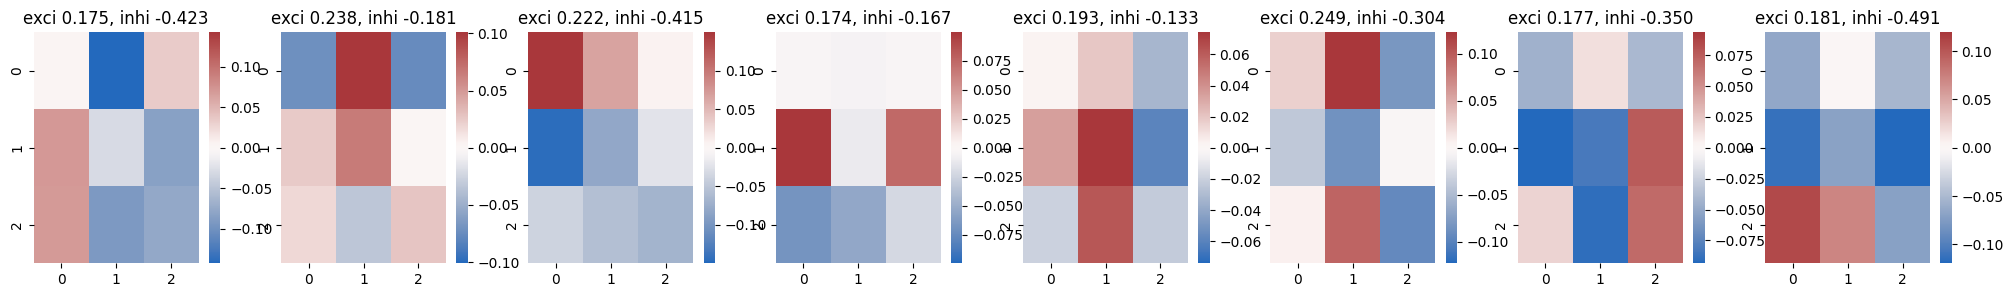

In [50]:
# deconv
deconv1 = model.deconv1.weight.detach().cpu().numpy()

fig, axs = plt.subplots(1, len(deconv1), figsize=(25, 3))
plt.title('deconv 1 kernels')
for i in range(len(deconv1)):
    abs_max = np.max(np.abs(deconv1[i]))
    sns.heatmap(deconv1[i].squeeze(), ax=axs[i], vmax=abs_max, vmin=-abs_max, cmap='vlag')
    axs[i].set_title('exci %.3f, inhi %.3f' % (((deconv1[i]>0)*deconv1[i]).sum(), ((deconv1[i]<0)*deconv1[i]).sum()))
plt.show()

(8, 8, 3, 3)


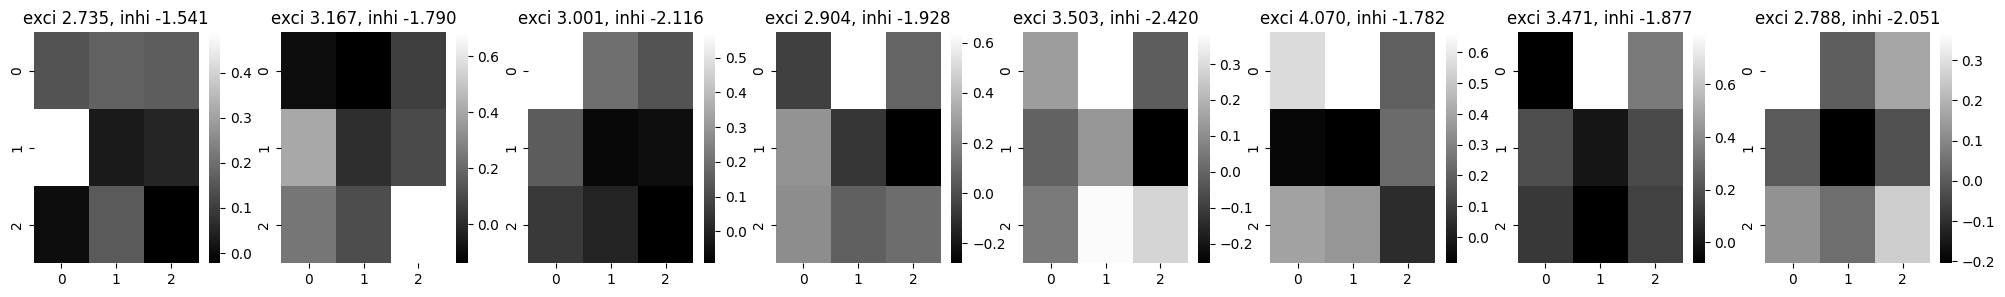

In [51]:
k2 = model.conv2.conv_in.weight.detach().cpu().numpy()

print(k2.shape)

fig, axs = plt.subplots(1, len(k), figsize=(25, 3))
plt.title('conv 1 kernels')
for i in range(len(k2)):
    sns.heatmap(k2[i].sum(axis=0), ax=axs[i], cmap='gray')
    axs[i].set_title('exci %.3f, inhi %.3f' % (((k2[i]>0)*k2[i]).sum(), ((k2[i]<0)*k2[i]).sum()))
plt.show()

(8, 8, 3, 3)


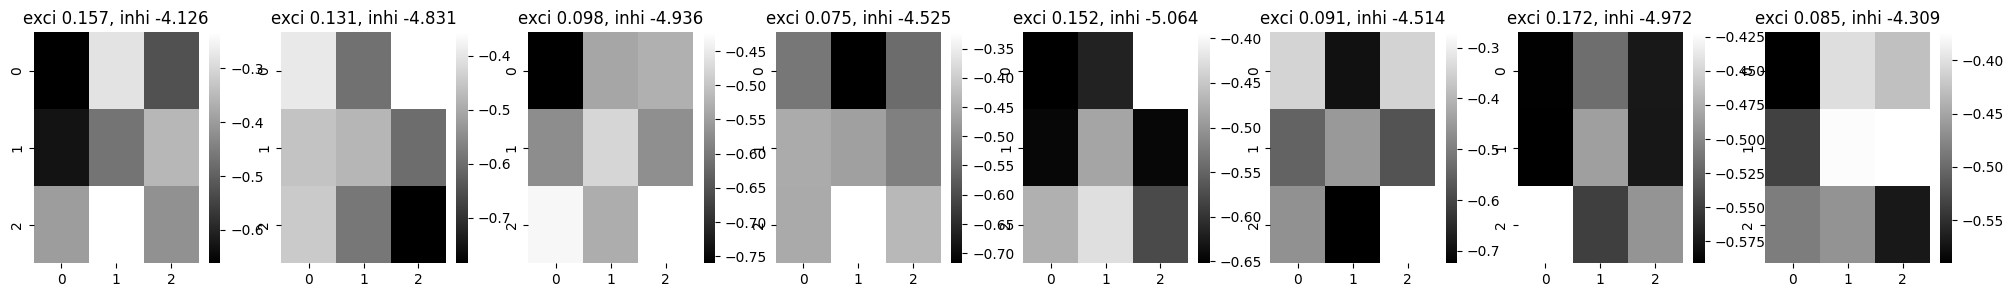

In [52]:
deconv2 = model.deconv2.weight.detach().cpu().numpy()

print(deconv2.shape)

fig, axs = plt.subplots(1, len(deconv2), figsize=(25, 3))
plt.title('conv 1 kernels')
for i in range(len(deconv2)):
    sns.heatmap(deconv2[i].sum(axis=0), ax=axs[i], cmap='gray')
    axs[i].set_title('exci %.3f, inhi %.3f' % (((deconv2[i]>0)*deconv2[i]).sum(), ((deconv2[i]<0)*deconv2[i]).sum()))
plt.show()

<AxesSubplot: >

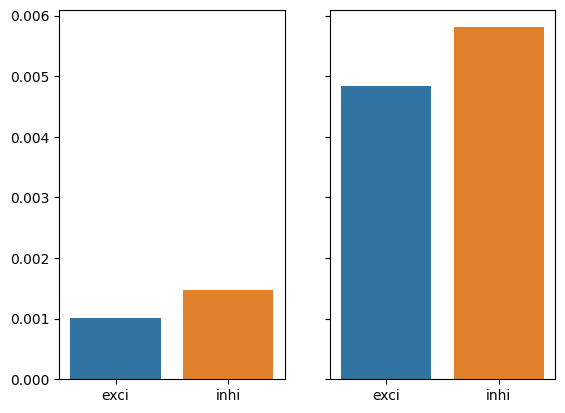

In [53]:
pop_to_conv = model.pop_to_conv.weight.detach().cpu()
conv_to_pop = model.conv_to_pop.weight.detach().cpu()

fig, axs = plt.subplots(1, 2, sharey=True)
sns.barplot(x=['exci', 'inhi'], y=[(pop_to_conv*(pop_to_conv>0)).numpy().mean(), -(pop_to_conv*(pop_to_conv<0)).numpy().mean()], ax=axs[0])
sns.barplot(x=['exci', 'inhi'], y=[(conv_to_pop*(conv_to_pop>0)).numpy().mean(), -(conv_to_pop*(conv_to_pop<0)).numpy().mean()], ax=axs[1])


In [54]:
pop_to_conv = model.pop_to_conv.weight.detach().cpu()
deconv1 = model.deconv1.weight.detach().cpu()
deconv1_bias = model.deconv1.bias.detach().cpu()
deconv2 = model.deconv2.weight.detach().cpu()
deconv2_bias = model.deconv2.bias.detach().cpu()
# deconv3 = model.deconv3.weight.detach().cpu()
# deconv3_bias = model.deconv3.bias.detach().cpu()
# deconv4 = model.deconv4.weight.detach().cpu()
# deconv4_bias = model.deconv4.bias.detach().cpu()

# per pop encoding neuron detection of input in input space 

def visualise(index):
    conv2_f = pop_to_conv[:, index*10:(index+1)*10].sum(dim=1).reshape(model.conv2.output_shape)
    conv1_f = torch.nn.functional.conv_transpose2d(conv2_f, deconv2, bias=deconv2_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)
    input = torch.nn.functional.conv_transpose2d(conv1_f, deconv1, bias=deconv1_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)

    return input

# def visualise(index):
#     conv4_f = ((pop_to_conv[:, index*10:(index+1)*10]>00)*pop_to_conv[:, index*10:(index+1)*10]).sum(dim=1).reshape(model.conv4.output_shape)
#     conv3_f = torch.nn.functional.conv_transpose2d(conv4_f, deconv4, bias=deconv4_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)
#     conv2_f = torch.nn.functional.conv_transpose2d(conv3_f, deconv3, bias=deconv3_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)
#     conv1_f = torch.nn.functional.conv_transpose2d(conv2_f, deconv2, bias=deconv2_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)
#     input = torch.nn.functional.conv_transpose2d(conv1_f, deconv1, bias=deconv1_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)

#     return input

# def visualise(index):
#     conv1_f = pop_to_conv[:, index*10:(index+1)*10].sum(dim=1).reshape(model.conv1.output_shape)
#     input = torch.nn.functional.conv_transpose2d(conv1_f, deconv1, bias=deconv1_bias, stride=1, padding=0, output_padding=0, groups=1, dilation=1)
#
#     return input


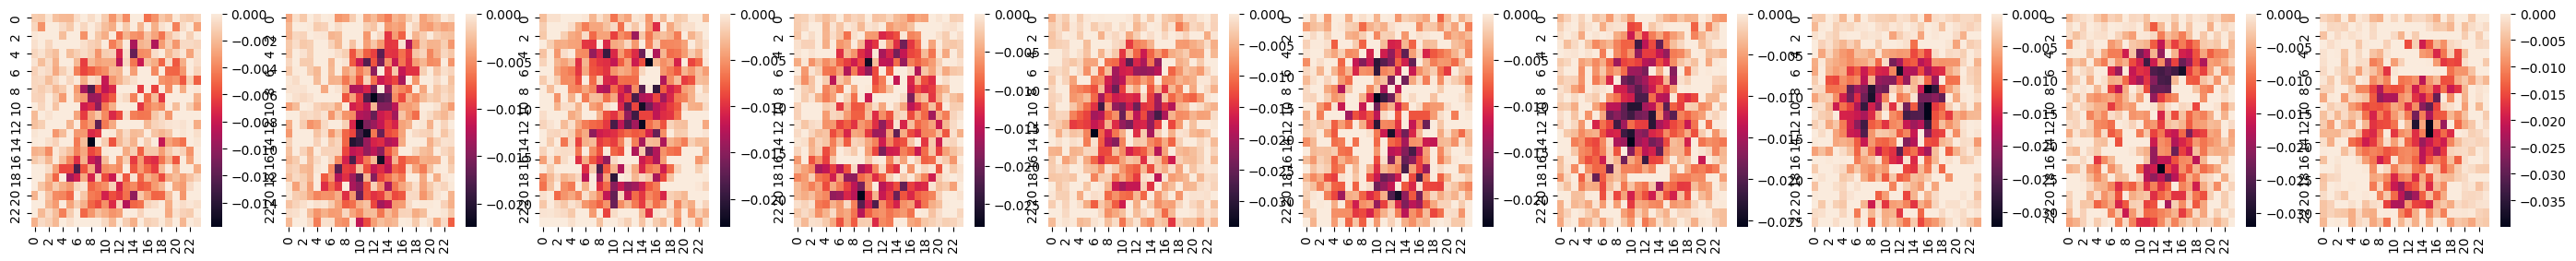

In [85]:
fig, axs = plt.subplots(1, 10, figsize=(35, 3))

for i in range(10):
    im = pop_to_conv[:, i*10:(i+1)*10].sum(dim=1).reshape(model.conv2.output_shape).mean(dim=0)
    sns.heatmap(im.squeeze(), ax=axs[i], vmax=0)

In [56]:
# get all hidden states
def save_to_cpu(hidden_):
    for i in range(len(hidden_)):
        hidden_[i] = list(hidden_[i])
        for j in range(len(hidden_[0])):
            hidden_[i][j] = hidden_[i][j].cpu()

    return hidden_

def get_all_analysis_data(trained_model, test_loader, device, IN_dim, T, conv=None):
    trained_model.eval()
    test_loss = 0
    correct = 0

    hiddens_all_ = []
    preds_all_ = []  # predictions at all timesptes
    data_all_ = []  # get transformed data 

    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        if i == 5:
            break
        data_all_.append(data.data)
        data, target = data.to(device), target.to(device)
        if conv is None:
            data = data.view(-1, IN_dim)

        with torch.no_grad():
            trained_model.eval()
            hidden = trained_model.init_hidden(data.size(0))

            log_softmax_outputs, hidden = trained_model.inference(data, hidden, T)
            hiddens_all_.append(save_to_cpu(hidden))

            test_loss += F.nll_loss(log_softmax_outputs[-1], target, reduction='sum').data.item()

            pred = log_softmax_outputs[-1].data.max(1, keepdim=True)[1]
            preds_all_.append(pred)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()
        

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_acc))

    data_all_ = torch.stack(data_all_).reshape(i*batch_size, 28, 28)
    preds_all_ = torch.stack(preds_all_).flatten().cpu().numpy()

    return hiddens_all_, preds_all_, data_all_, test_acc


hidden_all, preds_all, data_all, _ = get_all_analysis_data(model, test_loader, device, IN_dim, T, conv=True)


Test set: Average loss: 0.1292, Accuracy: 902/10000 (9%)



In [57]:
def get_states(hiddens_all_: list, idx: int, batch_size, T=20):
    """
    get a particular internal state depending on index passed to hidden
    :param hidden_dim_: the size of a state, eg. num of r or p neurons
    :param T: total time steps
    :param hiddens_all_: list containing hidden states of all batch and time steps during inference
    :param idx: which index in h is taken out
    :return: np array containing desired states
    """
    all_states = []
    for batch_idx in range(len(hiddens_all_)):  # iterate over batch
        batch_ = []
        for t in range(T):
            seq_ = []
            for b in range(batch_size):
                seq_.append(hiddens_all_[batch_idx][t][idx][b].detach().cpu().numpy())
            seq_ = np.stack(seq_)
            batch_.append(seq_)
        batch_ = np.stack(batch_)
        all_states.append(batch_)

    all_states = np.stack(all_states)

    return all_states

In [58]:
h_spks = get_states(hidden_all, 1, batch_size)

In [59]:
n_samples = 5*200
h_spks = h_spks.transpose(0, 2, 1, 3).reshape(n_samples, T, -1)
h_spks.shape

(1000, 20, 784)

In [60]:
conv1_spks = get_states(hidden_all, 5, batch_size)
conv2_spks = get_states(hidden_all, 9, batch_size)

print(conv1_spks.shape, conv2_spks.shape)

(5, 20, 200, 8, 26, 26) (5, 20, 200, 8, 24, 24)


In [61]:
conv1_spks = conv1_spks.transpose(0, 2, 1, 3, 4, 5).reshape(n_samples, T, model.conv1.output_shape[0], model.conv1.output_shape[1], model.conv1.output_shape[2])
conv2_spks = conv2_spks.transpose(0, 2, 1, 3, 4, 5).reshape(n_samples, T, model.conv2.output_shape[0], model.conv2.output_shape[1], model.conv2.output_shape[2])

In [62]:
# conv3_spks = get_states(hidden_all, 13, batch_size)
# conv3_spks = conv3_spks.transpose(0, 2, 1, 3, 4, 5).reshape(n_samples, T, model.conv3.output_shape[0], model.conv3.output_shape[1], model.conv3.output_shape[2])

In [63]:
pop_spks = get_states(hidden_all, 13, batch_size)
pop_spks = pop_spks.transpose(0, 2, 1, 3).reshape(n_samples, T, -1)
pop_spks.shape

(1000, 20, 100)

In [64]:
conv1_spks[0, 0].shape

(8, 26, 26)

In [65]:
sample_no = 3

fig, axs = plt.subplots(4, 20, figsize=(100, 20))
for t in range(T):
    # h layer spk
    sns.heatmap(h_spks[sample_no, t].reshape(28, 28), ax=axs[0, t])
    axs[0, t].set_title('h spk')

    # conv1
    sns.heatmap(conv1_spks[sample_no, t].mean(axis=0), ax=axs[1, t], vmin=0, vmax=1)
    axs[1, t].set_title('conv1 mean spk across channels')

    # conv2
    sns.heatmap(conv2_spks[sample_no, t].mean(axis=0), ax=axs[2, t], vmin=0, vmax=1)
    axs[2, t].set_title('conv2 mean spk across channels')

    # pop
    sns.heatmap(pop_spks[sample_no, t].reshape(10, 10), ax=axs[3, t], vmin=0, vmax=1)
    axs[3, t].set_title('pop spk')

plt.savefig(exp_dir + 'spk exp seq.png')
plt.close()

In [66]:
# top down sig
fig, axs = plt.subplots(4, 20, figsize=(100, 20))
for t in range(T):
    # h layer spk
    inhi1 = torch.conv_transpose2d(torch.tensor(conv1_spks[sample_no, t]), model.deconv1.weight.detach().cpu(), model.deconv1.bias.detach().cpu(), stride=1, padding=1)
    max1 = np.max(np.abs(inhi1.numpy()))
    sns.heatmap(inhi1.squeeze(), ax=axs[0, t], vmax=2, vmin=-2, cmap='vlag')
    axs[0, t].set_title('h fb')

    # conv1
    inhi2 = torch.conv_transpose2d(torch.tensor(conv2_spks[sample_no, t]), model.deconv2.weight.detach().cpu(), model.deconv2.bias.detach().cpu(), stride=1, padding=1)
    max2 = np.max(np.abs(inhi2.numpy()))
    sns.heatmap(inhi2.mean(axis=0), ax=axs[1, t], vmax=2, vmin=-2, cmap='vlag')
    axs[1, t].set_title('conv1 fb')

    # conv2
    inhi3 = (pop_to_conv @ pop_spks[sample_no, t]).reshape(model.conv2.output_shape[0], model.conv2.output_shape[1], model.conv2.output_shape[2])
    sns.heatmap(inhi3.mean(axis=0), ax=axs[2, t], vmin=-0.1, vmax=0.1, cmap='vlag')
    axs[2, t].set_title('conv2 fb')

    # pop
    rec = model.pop_enc.rec_w.weight.detach().cpu().numpy() @ pop_spks[sample_no, t]
    sns.heatmap(rec.reshape(10, 10), ax=axs[3, t], vmax=1, vmin=-1, cmap='vlag')
    axs[3, t].set_title('pop spk')

plt.savefig(exp_dir + str(sample_no) + 'top down sig.png')
plt.close()